In [5]:
import pandas as pd

pp = pd.read_csv('Top100_06_14_cleaned.csv')

In [6]:
from tqdm.notebook import tqdm

from openai import OpenAI
client = OpenAI()

def get_embeddings(texts, model="text-embedding-3-large"):
    # Replace newlines in each text and ensure it's a list of texts
    texts = [text.replace("\n", " ") for text in texts]
    # OpenAI's embeddings.create can process multiple inputs as a list
    response = client.embeddings.create(input=texts, model=model)
    # Extract embeddings from the response
    embeddings = [item.embedding for item in response.data]
    return embeddings

# Function to process DataFrame in batches and return a list of embeddings
def process_in_batches(df, column_name, batch_size=10):
    # Break the DataFrame into batches of size `batch_size`
    batches = [df[column_name].iloc[i:i + batch_size] for i in range(0, len(df), batch_size)]
    # Process each batch and collect embeddings
    all_embeddings = []
    for batch in tqdm(batches, desc="Processing batches"):
        batch_embeddings = get_embeddings(batch.tolist())
        all_embeddings.extend(batch_embeddings)
    return all_embeddings

In [7]:
# create a column short_text, to store the first 40000 characters of the cleaned_text
pp['short_text'] = pp['cleaned_text'].str[:40000]

In [8]:
# Example usage
batch_size = 100  # Adjust based on your preference and rate limits
pp['embedding'] = process_in_batches(pp, 'short_text', batch_size=batch_size)

Processing batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
pp['embedding']

0     [-0.049693964421749115, -0.058220043778419495,...
1     [-0.02793045900762081, -0.049050960689783096, ...
2     [-0.014031004160642624, -0.05111810192465782, ...
3     [-0.0074996198527514935, -0.04997127503156662,...
4     [-0.034652385860681534, -0.04386914148926735, ...
                            ...                        
95    [-0.04686970263719559, -0.008733822032809258, ...
96    [-0.03066966123878956, -0.06553814560174942, -...
97    [-0.02369970828294754, -0.05773090571165085, -...
98    [-0.037218108773231506, -0.013669508509337902,...
99    [-0.004864207468926907, -0.020809940993785858,...
Name: embedding, Length: 100, dtype: object

In [10]:
from sklearn.decomposition import PCA
import numpy as np

data = np.array(pp['embedding'].tolist())

# 创建 PCA 对象
pca = PCA(n_components=2)

# 使用 PCA 进行降维
X_pca = pca.fit_transform(data)

In [11]:
# Step -3: Color encoding
# Encode the category column to numerical values
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
color_encoded = le.fit_transform(pp['Category'])

/Users/apple/.pyenv/versions/3.11.6/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 65293 (\N{FULLWIDTH HYPHEN-MINUS}) missing from current font.
  func(*args, **kwargs)
/Users/apple/.pyenv/versions/3.11.6/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 65293 (\N{FULLWIDTH HYPHEN-MINUS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


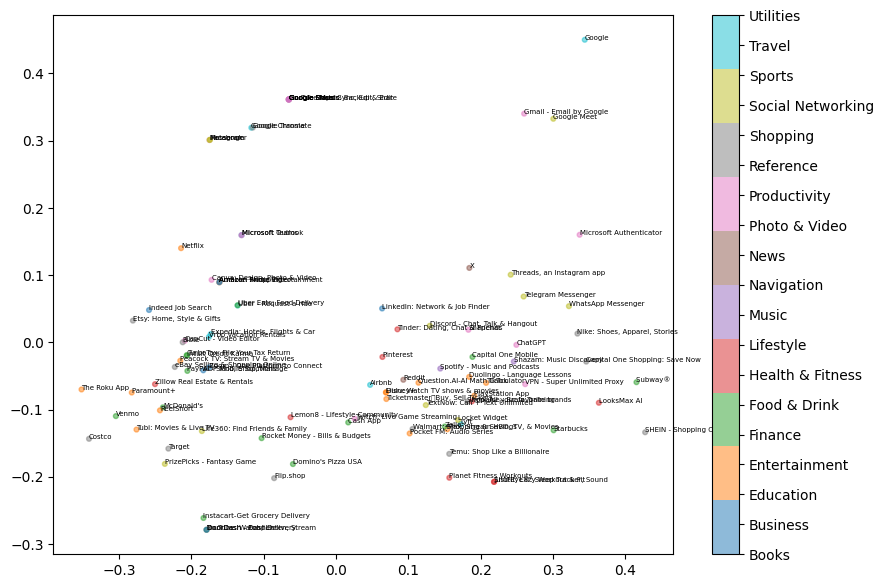

In [12]:
# import plt
import matplotlib.pyplot as plt
# Step 3: Plot the documents in 2D
plt.figure(figsize=(10, 7))

# Or for t-SNE plot
# plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c='blue')
# for i, doc in enumerate(documents):
#     plt.annotate(doc, (X_tsne[i, 0], X_tsne[i, 1]))

# Using PCA
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=color_encoded, cmap=plt.cm.tab10, alpha= 0.5, s = 12)

# Add a color bar to indicate the categories
plt.colorbar(scatter, ticks=range(len(le.classes_)), format=plt.FuncFormatter(lambda x, _: le.inverse_transform([int(x)])[0]))

# for i, doc in enumerate(documents):
#     plt.annotate(f"Doc {i+1}", (X_pca[i, 0], X_pca[i, 1]))
for i, name in enumerate(pp['Name']):
    plt.annotate(name, (X_pca[i, 0], X_pca[i, 1]), fontsize = 5)


In [13]:
import plotly.graph_objects as go

# Create a scatter plot
fig = go.Figure(data=go.Scatter(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    mode='markers',
    text=pp['Name'],  # Set the hover text to the 'name' column
    marker=dict(size=8, color = color_encoded)
))

# set height = width
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
)

# Show the plot
fig.show()

In [14]:
from sklearn.manifold import TSNE

data = np.array(pp['embedding'].tolist())

tsne = TSNE(n_components=2, random_state=0)

data_2d = tsne.fit_transform(data)

X_pca = data_2d

In [15]:
# Create a scatter plot
fig = go.Figure(data=go.Scatter(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    mode='markers',
    text=pp['Name'],  # Set the hover text to the 'name' column
    marker=dict(size=8, color = color_encoded)
))

# set height = width
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
)

# Show the plot
fig.show()